In [1]:
import matplotlib.pylab as plt
# import networkx as nx
import numpy as np
import pandas as pd
import time
import sys
import os

In [7]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

In [22]:
def compare_topic_queryset(runs, method='top_word_overlap', verbosity=0):

    col1s = []
    col2s = []
    ss = []
    scols = []

    stat = runs.first()

    if runs.count() == 1 and runs.first().method=="DT":
        windows = True
        runs = stat.periods.all().order_by('n')
    else:
        windows = False
        runs = runs.order_by('K').values_list('run_id',flat=True)

    for i in range(1,len(runs)):

        if windows:
            s1 = runs[i-1]
            s2 = runs[i]
            topics1 = Topic.objects.filter(run_id=stat.parent_run_id,period=s1)
            topics2 = Topic.objects.filter(run_id=stat.parent_run_id,period=s2)

        else:
            s1 = RunStats.objects.get(pk=runs[i-1])
            s2 = RunStats.objects.get(pk=runs[i])

            if s1.method=="DT":
                topics1 = DynamicTopic.objects.filter(run_id=runs[i-1])
            else:
                topics1 = Topic.objects.filter(run_id=runs[i-1])

            if s2.method=="DT":
                topics2 = DynamicTopic.objects.filter(run_id=runs[i])
            else:
                topics2 = Topic.objects.filter(run_id=runs[i])

        score_matrix = np.ndarray(shape=[len(topics1), len(topics2)])
        
        df = pd.DataFrame.from_dict(list(topics2.values('title','score')))
        #df2 = pd.DataFrame.from_dict([{'title': 'None','score': 0}])
        #df = df.append(df2)

        col1 = "run_{}_topics_{}".format(runs[i-1],topics1.count())
        scol = "scores_{}".format(runs[i])
        bscol = "scores_{}".format(runs[i-1])

        if i==1:
            scols.append(bscol)

        col1s.append(col1)
        scols.append(scol)

        col2 = "run_{}_topics_{}".format(runs[i], topics2.count())

        col2s.append(col2)

        s = "similarity_{}-{}".format(runs[i-1],runs[i])
        ss.append(s)

        df = df.rename(columns = {'title': col2, 'score': scol})

        df[s] = 0
        df[col1] = "None"
        df[bscol] = 0
        
        
        for j, t in enumerate(topics2):
            scores = [0]
            titles = [""]
            tscores = [0]

            if method is "top_word_overlap":

                for k, ct in enumerate(topics1):
                    score = len(set(t.top_words).intersection(set(ct.top_words)))
                    if score > 0:
                        scores.append(score)
                        titles.append(ct.title)
                        tscores.append(ct.score)

                    score_matrix[k][j] = score

            elif method is "score_product":

                terms2_scores = {term2.term_title: term2.score
                                 for term2 in TopicTerm.objects.filter(topic=t).annotate(term_title=F('term__title'))}
                count = TopicTerm.objects.filter(topic=t).count()
                if verbosity > 0:
                    print("computing scores for topic #{} {} ({} terms)".format(j, t.title, count))

                for k, ct in enumerate(topics1):
                    score = 0
                    terms2 = Topic
                    for term in TopicTerm.objects.filter(topic=ct).annotate(term_title=F('term__title')):
                        try:
                            score += term.score * terms2_scores[term.term_title]
                        except KeyError:
                            # print("KeyError: {}".format(term.term.title))
                            pass

                    scores.append(score)
                    titles.append(ct.title)
                    tscores.append(ct.score)

                    score_matrix[k][j] = score   

            m = max(scores)
            # df.loc[df[col2]==t.title, s] = m
            df.loc[df[col2]==t.title, s] = m
            if m==0:
                # df.loc[df[col2]==t.title, col1] = 'None'
                df.loc[df[col2]==t.title, col1] = 'None'
            else:
                #df.loc[df[col2]==t.title, col1] = titles[scores.index(max(scores))]
                #df.loc[df[col2]==t.title, bscol] = tscores[scores.index(max(scores))]
                df.loc[df[col2]==t.title, col1] = titles[scores.index(max(scores))]
                df.loc[df[col2]==t.title, bscol] = tscores[scores.index(max(scores))]
                
        if i==1:
            #df = pd.DataFrame.from_dict(list(topics2.values('title')))
            mdf = df
        else:
            mdf = mdf.merge(df,how="outer").fillna("")
        
        print(df.head())
        
        fig, ax = plt.subplots()
        cax = ax.imshow(score_matrix)
        plt.xticks(np.arange(len(topics2)), [t.title for t in topics2], rotation='vertical')
        plt.yticks(np.arange(len(topics1)),  [t.title for t in topics1])
        cbar = fig.colorbar(cax)

    columns = []
    for i in range(len(col1s)):
        columns.append(col1s[i])
        columns.append(scols[i])
        columns.append(ss[i])
        if i == len(col1s)-1:
            columns.append(col2s[i])
            columns.append(scols[i+1])

    print(columns)

    mdf = mdf[columns]

    res = mdf.groupby(columns)
    res = res.apply(lambda x: x.sort_values(s,ascending=False))

    return [res,ss, score_matrix]


def save_res(res, options):
    ss = res[1]
    res = res[0]

    if runs.count()==1 and runs.first().method=="DT":
        fname = "/tmp/run_compare_{}_windows.xlsx".format(stat.run_id)
    else:
        fname = "/tmp/run_compare_{}_{}.xlsx".format(runs[0].run_id,runs[len(runs)-1].run_id)
        if options["fname"] is not None:
            fname = "{}/run_compare_{}_{}.xlsx".format(options["fname"],runs[0].run_id,runs[len(runs)-1].run_id)

    writer = pd.ExcelWriter(fname, engine='xlsxwriter')

    res.to_excel(writer)

    worksheet = writer.sheets['Sheet1']

    cbase = ord('A')-1
    for i in range(len(ss)):
        n = (i+1)*3-1
        l1 = ''
        if n > 26:
            l1 = chr(cbase+n//26)
        c = l1+chr(cbase+n%26+1)
        r = "{}2:{}{}".format(c,c,len(res))
        print(r)

        worksheet.conditional_format(r, {
            'type': '3_color_scale',
            'min_value': 0,
            'mid_value': 5,
            'max_value': 10,
            'min_type': 'num',
            'mid_type': 'num',
            'max_type': 'num',
        })

    writer.save()
    return 0

In [ ]:
search = 
run_ids = RunStats.objects.filter(search=)
run_ids

   scores_67                    run_67_topics_20  similarity_66-67  \
0  28.466351                 {herr, dam, geehrt}                 8   
1  32.839900  {deutschland, bergrecht, rohstoff}                 6   
2  24.899311             {energiew, strom, kost}                10   
3  33.702962    {kohlekraftwerk, neu, kraftwerk}                 9   
4  32.293392          {kohl, aussteig, ausstieg}                 7   

                   run_66_topics_15  scores_66  
0               {herr, dam, geehrt}  30.572823  
1      {antrag, bergrecht, deutsch}  41.672827  
2            {energiew, strom, neu}  26.537905  
3  {kohlekraftwerk, neu, kraftwerk}  34.981997  
4             {kohl, aussteig, sag}  35.480996  
['run_66_topics_15', 'scores_66', 'similarity_66-67', 'run_67_topics_20', 'scores_67']
C2:C20


run_66_topics_15  \
run_66_topics_15                   scores_66 similarity_66-67 run_67_topics_20                        scores_67                                          
{antrag, bergrecht, deutsch}       41.672827 3                {antrag, grun, link}                    29.279634 9         {antrag, bergrecht, deutsch}   
                                             6                {deutschland, bergrecht, rohstoff}      32.839900 1         {antrag, bergrecht, deutsch}   
{ausschuss, drucksach, abgeordnet} 20.816817 9                {ausschuss, drucksach, abgeordnet}      19.299047 6   {ausschuss, drucksach, abgeordnet}   
{braunkohl, steinkohl, kwkziel}    21.676419 9                {braunkohl, kwkziel, steinkohl}         20.937754 7      {braunkohl, steinkohl, kwkziel}   
{energiew, strom, neu}             26.537905 10               {energiew, strom, kost}                 24.899311 2               {energiew, strom, neu}   
{erneuerbar, energi, ausbau}       35.749874 10               {erneuerbar, energi, ausbau}            35.116806 13        {erneuerbar, energi, ausbau}   
{euro, milliard, million}          29.567123 2                {million, tonn, einspar}                20.426370 8            {euro, milliard, million}   
                                             8                {euro, milliard, haushalt}              27.436245 15           {euro, milliard, million}   
{europa, emissionshandel, union}   28.685785 1                {kaltemittel, klimaanlag, bundesregier} 24.453351 18    {europa, emissionshandel, union}   
                                             8                {europa, emissionshandel, union}        27.996591 11    {europa, emissionshandel, union}   
{frag, bundesregier, schriftlich}  34.674559 4                {sag, frag, ganz}                       43.575649 5    {frag, bundesregier, schriftlich}   
{herr, dam, geehrt}                30.572823 8                {herr, dam, geehrt}                     28.466351 0                  {herr, dam, geehrt}   
{klimaschutz, deutschland, mehr}   37.513285 2                {geht, darum, natur}                    25.555956 19    {klimaschutz, deutschland, mehr}   
                                             4                {kohleausstieg, jahr, seit}             22.645221 17    {klimaschutz, deutschland, mehr}   
                                             6                {klimaschutz, mehr, deutschland}        29.065219 16    {klimaschutz, deutschland, mehr}   
{kohl, aussteig, sag}              35.480996 7                {kohl, aussteig, ausstieg}              32.293392 4                {kohl, aussteig, sag}   
{kohlekraftwerk, neu, kraftwerk}   34.981997 9                {kohlekraftwerk, neu, kraftwerk}        33.702962 3     {kohlekraftwerk, neu, kraftwerk}   
{lieb, kolleg, kolleginn}          27.040176 9                {lieb, kolleg, kolleginn}               25.503212 12           {lieb, kolleg, kolleginn}   
{mensch, strukturwandel, region}   40.975307 9                {mensch, region, strukturwandel}        34.906622 14    {mensch, strukturwandel, region}   
{prozent, jahr, anteil}            30.919181 9                {prozent, jahr, anteil}                 29.015189 10             {prozent, jahr, anteil}   

                                                                                                                    scores_66  \
run_66_topics_15                   scores_66 similarity_66-67 run_67_topics_20                        scores_67                 
{antrag, bergrecht, deutsch}       41.672827 3                {antrag, grun, link}                    29.279634 9   41.672827   
                                             6                {deutschland, bergrecht, rohstoff}      32.839900 1   41.672827   
{ausschuss, drucksach, abgeordnet} 20.816817 9                {ausschuss, drucksach, abgeordnet}      19.299047 6   20.816817   
{braunkohl, steinkohl, kwkziel}    21.676419 9                {braunkohl, kwkziel, steinkohl}       

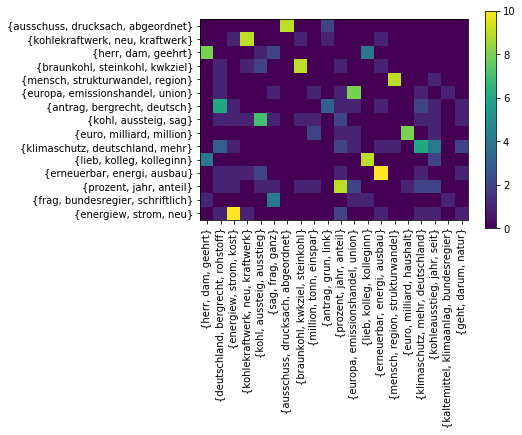

In [23]:
% matplotlib inline

runs = [66, 67]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs)
options = {'fname': "/media/Data/MCC/tmv_notebooks/comparison"}
save_res([res_tw,ss], options)
res_tw

   scores_67                    run_67_topics_20  similarity_66-67  \
0  28.466351                 {herr, dam, geehrt}          3.609405   
1  32.839900  {deutschland, bergrecht, rohstoff}          2.171324   
2  24.899311             {energiew, strom, kost}          2.818237   
3  33.702962    {kohlekraftwerk, neu, kraftwerk}          3.824795   
4  32.293392          {kohl, aussteig, ausstieg}          3.519647   

                   run_66_topics_15  scores_66  
0               {herr, dam, geehrt}  30.572823  
1      {antrag, bergrecht, deutsch}  41.672827  
2            {energiew, strom, neu}  26.537905  
3  {kohlekraftwerk, neu, kraftwerk}  34.981997  
4             {kohl, aussteig, sag}  35.480996  
['run_66_topics_15', 'scores_66', 'similarity_66-67', 'run_67_topics_20', 'scores_67']


run_66_topics_15  \
run_66_topics_15                   scores_66 similarity_66-67 run_67_topics_20                        scores_67                                          
{antrag, bergrecht, deutsch}       41.672827 1.280772         {kaltemittel, klimaanlag, bundesregier} 24.453351 18        {antrag, bergrecht, deutsch}   
                                             1.714400         {antrag, grun, link}                    29.279634 9         {antrag, bergrecht, deutsch}   
                                             2.171324         {deutschland, bergrecht, rohstoff}      32.839900 1         {antrag, bergrecht, deutsch}   
{ausschuss, drucksach, abgeordnet} 20.816817 4.784305         {ausschuss, drucksach, abgeordnet}      19.299047 6   {ausschuss, drucksach, abgeordnet}   
{braunkohl, steinkohl, kwkziel}    21.676419 3.017161         {braunkohl, kwkziel, steinkohl}         20.937754 7      {braunkohl, steinkohl, kwkziel}   
{energiew, strom, neu}             26.537905 2.818237         {energiew, strom, kost}                 24.899311 2               {energiew, strom, neu}   
{erneuerbar, energi, ausbau}       35.749874 4.338129         {erneuerbar, energi, ausbau}            35.116806 13        {erneuerbar, energi, ausbau}   
{euro, milliard, million}          29.567123 1.030070         {million, tonn, einspar}                20.426370 8            {euro, milliard, million}   
                                             3.355646         {euro, milliard, haushalt}              27.436245 15           {euro, milliard, million}   
{europa, emissionshandel, union}   28.685785 2.966370         {europa, emissionshandel, union}        27.996591 11    {europa, emissionshandel, union}   
{frag, bundesregier, schriftlich}  34.674559 2.644736         {sag, frag, ganz}                       43.575649 5    {frag, bundesregier, schriftlich}   
{herr, dam, geehrt}                30.572823 3.609405         {herr, dam, geehrt}                     28.466351 0                  {herr, dam, geehrt}   
{klimaschutz, deutschland, mehr}   37.513285 0.706103         {geht, darum, natur}                    25.555956 19    {klimaschutz, deutschland, mehr}   
                                             1.222652         {kohleausstieg, jahr, seit}             22.645221 17    {klimaschutz, deutschland, mehr}   
                                             2.874156         {klimaschutz, mehr, deutschland}        29.065219 16    {klimaschutz, deutschland, mehr}   
{kohl, aussteig, sag}              35.480996 3.519647         {kohl, aussteig, ausstieg}              32.293392 4                {kohl, aussteig, sag}   
{kohlekraftwerk, neu, kraftwerk}   34.981997 3.824795         {kohlekraftwerk, neu, kraftwerk}        33.702962 3     {kohlekraftwerk, neu, kraftwerk}   
{lieb, kolleg, kolleginn}          27.040176 3.542273         {lieb, kolleg, kolleginn}               25.503212 12           {lieb, kolleg, kolleginn}   
{mensch, strukturwandel, region}   40.975307 3.032566         {mensch, region, strukturwandel}        34.906622 14    {mensch, strukturwandel, region}   
{prozent, jahr, anteil}            30.919181 3.500858         {prozent, jahr, anteil}                 29.015189 10             {prozent, jahr, anteil}   

                                                                                                                    scores_66  \
run_66_topics_15                   scores_66 similarity_66-67 run_67_topics_20                        scores_67                 
{antrag, bergrecht, deutsch}       41.672827 1.280772         {kaltemittel, klimaanlag, bundesregier} 24.453351 18  41.672827   
                                             1.714400         {antrag, grun, link}                    29.279634 9   41.672827   
                                             2.171324         {deutschland, bergrecht, rohstoff}      32.839900 1   41.672827   
{ausschuss, drucksach, abgeordnet} 20.816817 4.784305         {ausschuss, drucksach, abgeordnet}    

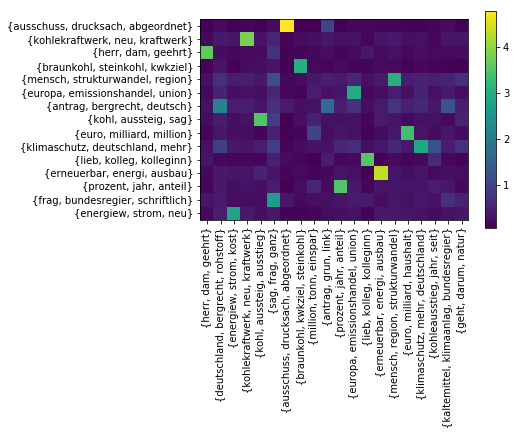

In [24]:
res, ss, score_prod_matrix = compare_topic_queryset(runs, method="score_product")
res

In [25]:
for i in range(len(score_prod_matrix)):
    score_prod_matrix[i] = score_prod_matrix[i] / np.sum(score_prod_matrix[i])

for i in range(len(score_matrix)):
    score_matrix[i] = score_matrix[i] / np.sum(score_matrix[i])

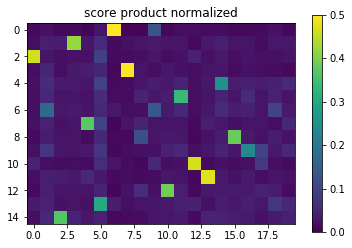

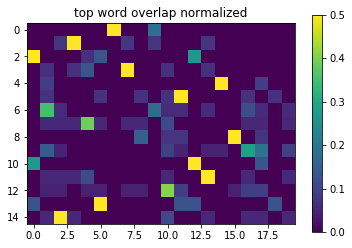

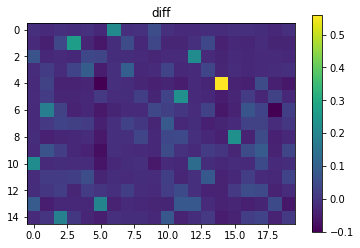

In [20]:
vmax = 0.5
fig, ax = plt.subplots()
plt.title("score product normalized")
cax = ax.imshow(score_prod_matrix, vmin=0, vmax=vmax)
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
plt.title("top word overlap normalized")
cax = ax.imshow(score_matrix, vmin=0, vmax=vmax)
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
plt.title("diff")
cax = ax.imshow(score_matrix - score_prod_matrix)
cbar = fig.colorbar(cax)

In [104]:
stat1 = RunStats.objects.get(pk=67)

for i, topic in enumerate(Topic.objects.filter(run_id=stat1.parent_run_id)):
    print("#{}: {}".format(i, topic.top_words))

#0: ['herr', 'dam', 'geehrt', 'prasident', 'verehrt', 'minist', 'prasidentin', 'gabriel', 'frau', 'heut']
#1: ['deutschland', 'bergrecht', 'rohstoff', 'deutsch', 'bergbau', 'mehr', 'forder', 'unternehm', 'land', 'heimisch']
#2: ['energiew', 'strom', 'kost', 'neu', 'kohlestrom', 'atomkraft', 'deutschland', 'teur', 'glaub', 'eeg']
#3: ['kohlekraftwerk', 'neu', 'kraftwerk', 'alt', 'bau', 'netz', 'nordrheinwestfal', 'datteln', 'brauch', 'modern']
#4: ['kohl', 'aussteig', 'ausstieg', 'brauch', 'sag', 'erreich', 'gas', 'erd', 'fossil', 'kernenergi']
#5: ['sag', 'frag', 'ganz', 'schon', 'gibt', 'eigent', 'bundesregier', 'gut', 'gesagt', 'stell']
#6: ['ausschuss', 'drucksach', 'abgeordnet', 'berat', 'fraktion', 'beschlussempfehl', 'uberweisungsvorschlag', 'tagesordnungspunkt', 'bundnis', 'aussprach']
#7: ['braunkohl', 'kwkziel', 'steinkohl', 'heimisch', 'kraftwerk', 'subventionsfrei', 'erreich', 'energietrag', 'revi', 'nein']
#8: ['million', 'tonn', 'einspar', 'emissionshandel', 'jahrlich', 'v

In [55]:
stat2 = RunStats.objects.get(pk=67)

for i, topic in enumerate(Topic.objects.filter(run_id=stat2.parent_run_id)):
    print("#{}: {}".format(i, topic))

#0: {herr, dam, geehrt}
#1: {deutschland, bergrecht, rohstoff}
#2: {energiew, strom, kost}
#3: {kohlekraftwerk, neu, kraftwerk}
#4: {kohl, aussteig, ausstieg}
#5: {sag, frag, ganz}
#6: {ausschuss, drucksach, abgeordnet}
#7: {braunkohl, kwkziel, steinkohl}
#8: {million, tonn, einspar}
#9: {antrag, grun, link}
#10: {prozent, jahr, anteil}
#11: {europa, emissionshandel, union}
#12: {lieb, kolleg, kolleginn}
#13: {erneuerbar, energi, ausbau}
#14: {mensch, region, strukturwandel}
#15: {euro, milliard, haushalt}
#16: {klimaschutz, mehr, deutschland}
#17: {kohleausstieg, jahr, seit}
#18: {kaltemittel, klimaanlag, bundesregier}
#19: {geht, darum, natur}


In [22]:
update_topic_scores(69)